<a href="https://colab.research.google.com/github/sumeghSinghchouhan/Automatic_Ticket_Classification_Assignment/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [24]:
import datetime

start_time = datetime.datetime.now()
print(f"Project execution started at: {start_time}")

Project execution started at: 2025-07-30 16:45:06.534869


Downloading Dataset

In [25]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
100% 83.4M/83.4M [00:00<00:00, 132MB/s]


## Importing the necessary libraries

In [26]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [27]:
# Define JSON file Path
f = '/content/drive/My Drive/complaints-2021-05-14_08_16.json'

# Opening JSON file and storing it in a Pandas Dataframe
with open(f, 'r', encoding="utf-8") as file:
    # Loading data as a dictionary
    data = json.load(file)
df = pd.json_normalize(data)
df=pd.json_normalize(data)

## Data preparation

In [28]:
# Inspect the dataframe to understand the given data.
pd.set_option("display.max_columns", None)  # Show all columns
print(df.head(3))

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   

       _source.date_received _source.state _source.consumer_disputed  \
0  2019-04-13T12:00:00-05:00            CA                       N/A   
1  2019-05-01T12:00:00-05:00            GA                       N/A   
2  2019-04-02T12:00:00-05:00            TX                       N/A   

               _source.product _source.company_response       _source.company  \
0              Debt collection  Clos

In [29]:
# Print the column names
print(df.shape)
print(df.columns)

(78313, 22)
Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [30]:
#Assign new column names

# Selecting only required columns
df = df[["_source.complaint_what_happened", "_source.product"]]

# Renaming columns for better readability
df.rename(columns={"_source.complaint_what_happened": "complaint_text",
                   "_source.product": "product"}, inplace=True)

# Checking the dataset again
df.head()

/tmp/ipython-input-4031339013.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_text,product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [31]:
# Assign nan in place of blanks in the complaints column
df['complaint_text'] = df['complaint_text'].replace('', np.nan)

# Check the number of null values after replacement
df.isnull().sum()

,0
complaint_text,57241
product,0


In [32]:
# Dropping rows where complaint_text is missing
df.dropna(subset=["complaint_text"], inplace=True)

# Removing complaints that are empty strings
df = df[df["complaint_text"].str.strip() != ""]

# Checking if missing values still exist
df.isnull().sum()

,0
complaint_text,0
product,0


In [33]:
df.head()

,complaint_text,product
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [34]:
# Function to clean the text and remove all the unnecessary elements.

import re

def clean_text(text):
    """
    Cleans the input text by removing special characters, numbers, and extra spaces.
    Converts text to lowercase.

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [35]:
# Function to Lemmatize the texts

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download necessary NLTK data files (if not already downloaded)
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(text):
    """
    Lemmatizes the input text by reducing words to their base or root form.

    Args:
        text (str): The input text to be lemmatized.

    Returns:
        str: The lemmatized text.
    """
    lemmatizer = WordNetLemmatizer()
    # Tokenize the text into words
    words = word_tokenize(text)
    # Lemmatize each word and join them back into a single string
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized_text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [36]:
%%time
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

# Apply the cleaning and lemmatization functions
df['cleaned_complaints'] = df['complaint_text'].apply(clean_text)  # Assuming clean_text is already defined
df['lemmatized_complaints'] = df['cleaned_complaints'].apply(lemmatize_text)  # Assuming lemmatize_text is already defined

# Create a new DataFrame with only the complaints and lemmatized complaints
df_clean = df[['complaint_text', 'lemmatized_complaints']]

CPU times: user 34.2 s, sys: 162 ms, total: 34.3 s
Wall time: 35.9 s


In [37]:
# Print new Dataset
print(df_clean.shape)
df_clean.head()

(21072, 2)


,complaint_text,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...


In [38]:
%%time
# Function to extract the POS tags

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

def filter_nouns(text):
    """
    Extracts and keeps only the nouns (NN) from the input text.

    Args:
        text (str): The input text to process.

    Returns:
        str: Text containing only nouns.
    """
    # Tokenize the text
    words = word_tokenize(text)
    # Get POS tags for each word
    pos_tags = pos_tag(words)
    # Filter words with the tag "NN" (noun)
    nouns = [word for word, tag in pos_tags if tag == "NN"]
    # Join the nouns back into a single string
    return ' '.join(nouns)

# Apply the function to the lemmatized complaints
print("Filtering nouns from lemmatized complaints...")
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].apply(filter_nouns)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Filtering nouns from lemmatized complaints...
CPU times: user 2min 41s, sys: 731 ms, total: 2min 42s
Wall time: 2min 51s


<timed exec>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
print(df_clean.shape)
df_clean.head()

(21072, 3)


,complaint_text,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and wa to...,i card wa agent upgrade date agent wa informat...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,card wa xxxx application identity consent serv...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




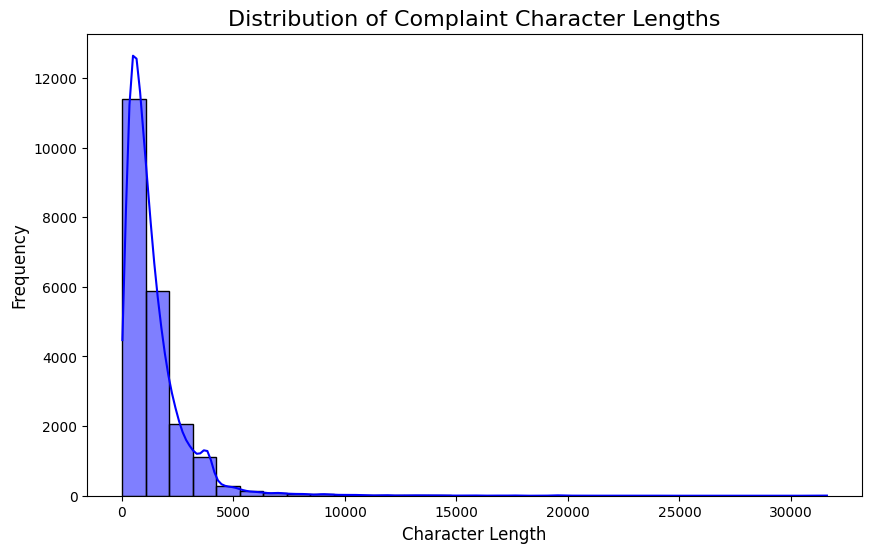

In [40]:
# Visualise the data according to the 'Complaint' character length

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the character length of each complaint
df_clean['complaint_length'] = df_clean['complaint_text'].apply(len)

# Plot a histogram to visualize the distribution of complaint lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Complaint Character Lengths', fontsize=16)
plt.xlabel('Character Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [41]:
# %pip install wordcloud

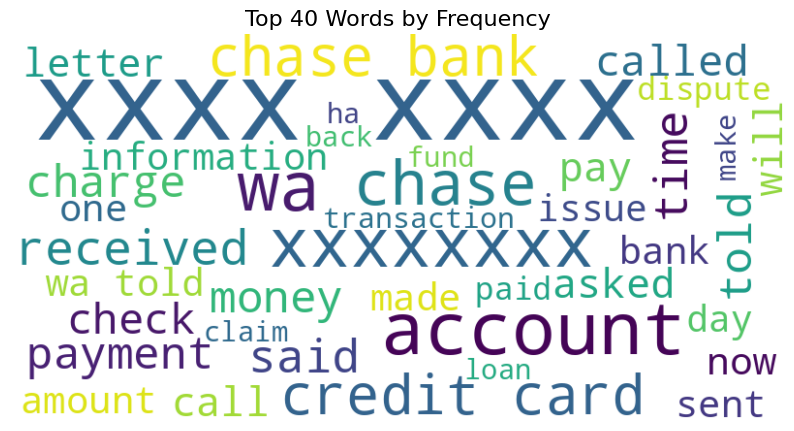

In [42]:
#Using a word cloud finding the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

# Combine all lemmatized complaints into a single string
all_text = ' '.join(df_clean['lemmatized_complaints'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency', fontsize=16)
plt.show()

In [43]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [44]:
# Code to find the top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean).

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Function to get top n unigrams
def get_top_unigrams(corpus, n=30):
    """
    Finds the top n unigrams by frequency in the given corpus.

    Args:
        corpus (list or Series): The text data to analyze.
        n (int): The number of top unigrams to return.

    Returns:
        DataFrame: A DataFrame containing unigrams and their frequencies.
    """
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    unigram_counts = X.sum(axis=0).A1
    unigram_names = vectorizer.get_feature_names_out()
    unigram_freq = list(zip(unigram_names, unigram_counts))
    sorted_unigrams = sorted(unigram_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_unigrams, columns=['Unigram', 'Frequency'])

# Get the top 30 unigrams
top_unigrams_df = get_top_unigrams(df_clean['lemmatized_complaints'], n=30)

print(top_unigrams_df)

        Unigram  Frequency
0          xxxx     202735
1         chase      80391
2            wa      79934
3       account      48624
4        credit      33101
5          card      30533
6      xxxxxxxx      29284
7          bank      28242
8       payment      21180
9          told      16380
10         time      16050
11          did      15989
12           ha      14023
13       called      13405
14       charge      13337
15          day      13248
16     received      12861
17        money      11962
18        check      11793
19         loan      10989
20         said      10883
21       letter       9679
22  information       9660
23          fee       8954
24  transaction       8656
25       number       8615
26        month       8523
27       report       8473
28         year       8400
29         sent       8329


In [45]:
#Print the top 10 words in the unigram frequency

top_10_unigrams_df = get_top_unigrams(df_clean['lemmatized_complaints'], n=10)

print("Top 10 Unigrams by Frequency:")
print(top_10_unigrams_df)

Top 10 Unigrams by Frequency:
    Unigram  Frequency
0      xxxx     202735
1     chase      80391
2        wa      79934
3   account      48624
4    credit      33101
5      card      30533
6  xxxxxxxx      29284
7      bank      28242
8   payment      21180
9      told      16380


In [46]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned dataframe(df_clean).

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize CountVectorizer for bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=30)

# Fit and transform the lemmatized complaints
bigram_matrix = bigram_vectorizer.fit_transform(df_clean['lemmatized_complaints'])

# Sum up the occurrences of each bigram
bigram_counts = bigram_matrix.sum(axis=0).A1

# Create a DataFrame for bigram frequencies
bigram_frequencies = pd.DataFrame({
    'Bigram': bigram_vectorizer.get_feature_names_out(),
    'Frequency': bigram_counts
}).sort_values(by='Frequency', ascending=False)

# Display the top 30 bigrams
print("Top 30 Bigrams by Frequency:")
print(bigram_frequencies)

Top 30 Bigrams by Frequency:
         Bigram  Frequency
29    xxxx xxxx      73846
12       of the      16941
9    my account      13806
24       to the      13483
3   credit card      12753
2    chase bank      12628
6        in the      11872
28     xxxx and      11420
16  on xxxxxxxx      10514
14       on the      10487
15      on xxxx      10353
10    my credit       9743
5       for the       9618
13        on my       9196
4       did not       9083
17     that the       8969
7       in xxxx       8912
8         it wa       7754
21     the xxxx       7666
23        to my       7587
19  the account       7463
27     with the       7257
22        to be       7206
0       and the       7199
18    that they       7074
11        of my       6946
1      and they       6853
26   with chase       6314
25      to xxxx       6300
20     the bank       6165


In [47]:
#Print the top 10 words in the bigram frequency
print("Top 10 Bigrams by Frequency:")
print(bigram_frequencies.head(10))

Top 10 Bigrams by Frequency:
         Bigram  Frequency
29    xxxx xxxx      73846
12       of the      16941
9    my account      13806
24       to the      13483
3   credit card      12753
2    chase bank      12628
6        in the      11872
28     xxxx and      11420
16  on xxxxxxxx      10514
14       on the      10487


In [48]:
# Code to find the top 30 trigram frequency among the complaints in the cleaned dataframe(df_clean).

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize CountVectorizer for trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=30)

# Fit and transform the lemmatized complaints
trigram_matrix = trigram_vectorizer.fit_transform(df_clean['lemmatized_complaints'])

# Sum up the occurrences of each trigram
trigram_counts = trigram_matrix.sum(axis=0).A1

# Create a DataFrame for trigram frequencies
trigram_frequencies = pd.DataFrame({
    'Trigram': trigram_vectorizer.get_feature_names_out(),
    'Frequency': trigram_counts
}).sort_values(by='Frequency', ascending=False)

# Display the top 30 trigrams
print("Top 30 Trigrams by Frequency:")
print(trigram_frequencies)

Top 30 Trigrams by Frequency:
                Trigram  Frequency
29       xxxx xxxx xxxx      31386
28        xxxx xxxx and       3998
16         on xxxx xxxx       3839
11     my credit report       2876
27        xxxx and xxxx       2638
10       my credit card       2392
22         to xxxx xxxx       2382
14         on my credit       2366
6       jp morgan chase       2328
23         told me that       2089
19        the xxxx xxxx       2086
3     chase credit card       1990
17        the amount of       1954
5          in xxxx xxxx       1897
4        from xxxx xxxx       1874
24         wa told that       1833
2          at xxxx xxxx       1822
0           and wa told       1811
13        on my account       1605
21        to my account       1531
7        my account and       1516
1         and xxxx xxxx       1470
18      the credit card       1432
25      with chase bank       1409
20         they told me       1409
26       with xxxx xxxx       1367
12         of xxxx xxxx  

In [49]:
#Print the top 10 words in the trigram frequency
print("Top 10 Trigrams by Frequency:")
print(trigram_frequencies.head(10))

Top 10 Trigrams by Frequency:
             Trigram  Frequency
29    xxxx xxxx xxxx      31386
28     xxxx xxxx and       3998
16      on xxxx xxxx       3839
11  my credit report       2876
27     xxxx and xxxx       2638
10    my credit card       2392
22      to xxxx xxxx       2382
14      on my credit       2366
6    jp morgan chase       2328
23      told me that       2089


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [50]:
df_clean['complaint_text'] = df_clean['complaint_text'].apply(lambda x: re.sub(r'\bxxxx\b', '', x, flags=re.IGNORECASE))


In [51]:
#All masked texts has been removed
df_clean.head()

,complaint_text,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is and I appreciate it ...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...
2,I upgraded my card in XX/XX/2018 and was tol...,i upgraded my xxxx xxxx card in xxxx and wa to...,i card wa agent upgrade date agent wa informat...,355,i card wa agent upgrade date agent wa informat...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,card wa xxxx application identity consent serv...,224,card wa xxxx application identity consent serv...
11,"On XX/XX/2018, while trying to book a tick...",on xxxx while trying to book a xxxx xxxx ticke...,book xxxx ticket i offer ticket card i informa...,1502,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [52]:
# Initialise the TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the lemmatized complaints to create the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['lemmatized_complaints'])

# Display the shape of the resulting TF-IDF matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (21072, 14271)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [53]:
# Code to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Create the Document-Term Matrix (DTM) using the TF-IDF vectorizer
dtm = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

# Display the shape of the DTM
print("Document-Term Matrix Shape:", dtm.shape)

# Display the first few rows of the DTM
print(dtm.head())

Streaming output truncated to the last 5000 lines.
3        0.0   0.0    0.0     0.0     0.0      0.0      0.0      0.0   
4        0.0   0.0    0.0     0.0     0.0      0.0      0.0      0.0   

   planning  plansm  plant  planted  plastic  plat  plate  platform  platinum  \
0       0.0     0.0    0.0      0.0      0.0   0.0    0.0       0.0       0.0   
1       0.0     0.0    0.0      0.0      0.0   0.0    0.0       0.0       0.0   
2       0.0     0.0    0.0      0.0      0.0   0.0    0.0       0.0       0.0   
3       0.0     0.0    0.0      0.0      0.0   0.0    0.0       0.0       0.0   
4       0.0     0.0    0.0      0.0      0.0   0.0    0.0       0.0       0.0   

   plausible  play  playbook  played  player  playing  playstation  plea  \
0        0.0   0.0       0.0     0.0     0.0      0.0          0.0   0.0   
1        0.0   0.0       0.0     0.0     0.0      0.0          0.0   0.0   
2        0.0   0.0       0.0     0.0     0.0      0.0          0.0   0.0   
3        0.0 

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

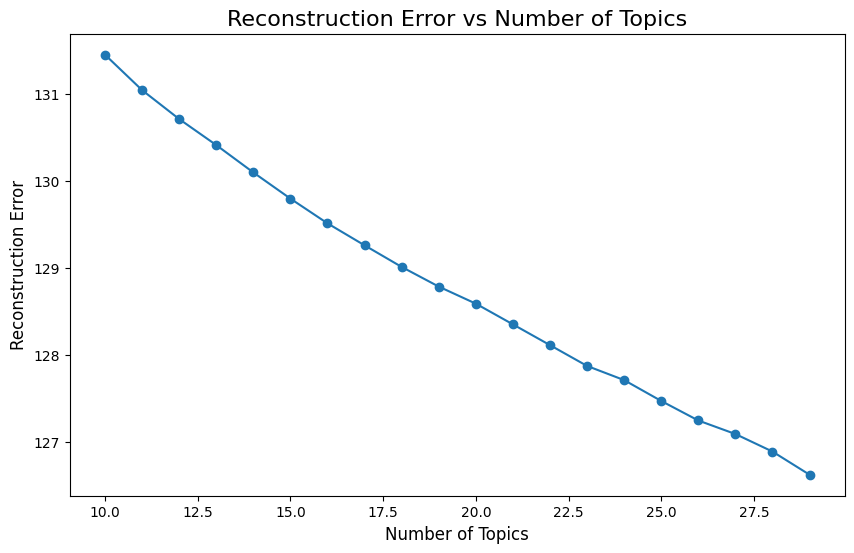

CPU times: user 4min 41s, sys: 471 ms, total: 4min 41s
Wall time: 2min 49s


In [54]:
%%time
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# Find the best number of clusters using reconstruction error
errors = []
num_topics = range(10, 30)  # Test for n to n clusters
for n in num_topics:
    nmf_model = NMF(n_components=n, random_state=42, max_iter=500)
    nmf_model.fit(tfidf_matrix)
    errors.append(nmf_model.reconstruction_err_)

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(num_topics, errors, marker='o')
plt.title('Reconstruction Error vs Number of Topics', fontsize=16)
plt.xlabel('Number of Topics', fontsize=12)
plt.ylabel('Reconstruction Error', fontsize=12)
plt.show()

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [55]:
# Load your nmf_model with the n_components i.e 5
num_topics = 4

# Keep the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40, max_iter=500)

In [56]:
%%time
nmf_model.fit(dtm)
len(tfidf_vectorizer.get_feature_names_out())

CPU times: user 2min 10s, sys: 5.42 s, total: 2min 15s
Wall time: 1min 24s


14271

In [57]:
# Print the Top15 words for each of the topics

# Get the feature names (terms) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Number of top words to display for each topic
num_top_words = 15

# Print the top words for each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()

Topic 1:
xxxx chase xxxxxxxx bank wa number charge dispute email transaction sent claim complaint refund received

Topic 2:
account wa bank check chase money fund told closed checking day deposit transaction called branch

Topic 3:
credit card report chase inquiry charge wa company xxxxxxxx balance score hard account reporting dispute

Topic 4:
payment loan mortgage wa xxxxxxxx chase late month modification home paid pay time year balance



In [58]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# Create the document-topic matrix (W)
W = nmf_model.transform(tfidf_matrix)

# Assign the best topic for each complaint
df_clean['Best_Topic'] = W.argmax(axis=1)

# Display the DataFrame with the assigned topics
print(df_clean[['complaint_text', 'Best_Topic']].head())

                                       complaint_text  Best_Topic
1   Good morning my name is   and I appreciate it ...           0
2   I upgraded my   card in XX/XX/2018 and was tol...           0
10  Chase Card was reported on XX/XX/2019. However...           2
11  On XX/XX/2018, while trying to book a     tick...           2
14  my grand son give me check for {$1600.00} i de...           1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but NMF was fitted with feature names



In [59]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] =  W.argmax(axis=1)


In [60]:
print(df_clean.shape)
print(df_clean.isnull().sum())

(21072, 7)
complaint_text           0
lemmatized_complaints    0
complaint_POS_removed    0
complaint_length         0
Complaint_clean          0
Best_Topic               0
Topic                    0
dtype: int64


In [61]:
df_clean.dropna(subset=["Topic"], inplace=True)
print(df_clean.shape)
print(df_clean.isnull().sum())
df_clean.head()

(21072, 7)
complaint_text           0
lemmatized_complaints    0
complaint_POS_removed    0
complaint_length         0
Complaint_clean          0
Best_Topic               0
Topic                    0
dtype: int64


,complaint_text,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Best_Topic,Topic
1,Good morning my name is and I appreciate it ...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,0,0
2,I upgraded my card in XX/XX/2018 and was tol...,i upgraded my xxxx xxxx card in xxxx and wa to...,i card wa agent upgrade date agent wa informat...,355,i card wa agent upgrade date agent wa informat...,0,0
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,card wa xxxx application identity consent serv...,224,card wa xxxx application identity consent serv...,2,2
11,"On XX/XX/2018, while trying to book a tick...",on xxxx while trying to book a xxxx xxxx ticke...,book xxxx ticket i offer ticket card i informa...,1502,book xxxx ticket i offer ticket card i informa...,2,2
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,1,1


In [62]:
#Print the first 5 Complaint for each of the Topics
df_preview = df_clean.groupby('Topic').head(5)

# Sort the resulting DataFrame by the 'Topic' column
df_preview = df_preview.sort_values('Topic')

# Display the preview DataFrame
df_preview

,complaint_text,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Best_Topic,Topic
1,Good morning my name is and I appreciate it ...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,0,0
2,I upgraded my card in XX/XX/2018 and was tol...,i upgraded my xxxx xxxx card in xxxx and wa to...,i card wa agent upgrade date agent wa informat...,355,i card wa agent upgrade date agent wa informat...,0,0
48,"JP Morgan Chase Bank, please answer the follow...",jp morgan chase bank please answer the followi...,jp bank please question xxxxxxxx chase informa...,1229,jp bank please question xxxxxxxx chase informa...,0,0
45,I made a purchase with on XX/XX/2019 in the...,i made a purchase with xxxx xxxx xxxx on xxxx ...,i purchase amount i transaction i dispute case...,1920,i purchase amount i transaction i dispute case...,0,0
40,"a sofa, love seat, table and chairs and was ...",xxxx xxxx a sofa love seat table and chair and...,xxxx love seat table chair wa debit card bank ...,165,xxxx love seat table chair wa debit card bank ...,0,0
21,"On XX/XX/2019, I made a {$300.00} payment to ...",on xxxx xxxx i made a payment to an online ret...,i payment retailer pay xxxx chase website i sc...,3541,i payment retailer pay xxxx chase website i sc...,1,1
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday i branch c...,2277,jp chase account debit card tuesday i branch c...,1,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,1,1
24,mishandling of this account by Chase auto and .,mishandling of this account by chase auto and ...,mishandling account auto xxxx,51,mishandling account auto xxxx,1,1
27,I opened an account with chase bank on and us...,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i term everythi...,413,i account bank xxxx code bonus i term everythi...,1,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [63]:
# Dictionary of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [64]:
df_clean.head()

,complaint_text,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Best_Topic,Topic
1,Good morning my name is and I appreciate it ...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,0,Bank Account services
2,I upgraded my card in XX/XX/2018 and was tol...,i upgraded my xxxx xxxx card in xxxx and wa to...,i card wa agent upgrade date agent wa informat...,355,i card wa agent upgrade date agent wa informat...,0,Bank Account services
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,card wa xxxx application identity consent serv...,224,card wa xxxx application identity consent serv...,2,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a tick...",on xxxx while trying to book a xxxx xxxx ticke...,book xxxx ticket i offer ticket card i informa...,1502,book xxxx ticket i offer ticket card i informa...,2,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,1,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [65]:
# Create the dictionary again of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}
# Replace numeric topic values with topic names
df_clean['Topic_Name'] = df_clean['Best_Topic'].map(Topic_names)

# Create a reverse dictionary to map topic names back to numeric values
Topic_numbers = {v: k for k, v in Topic_names.items()}

# Replace topic names with numeric values for supervised learning
df_clean['Topic'] = df_clean['Topic_Name'].map(Topic_numbers)

# Display the DataFrame with numeric topic labels
print(df_clean[['complaint_text', 'Topic_Name', 'Topic']].head())

                                       complaint_text  \
1   Good morning my name is   and I appreciate it ...   
2   I upgraded my   card in XX/XX/2018 and was tol...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a     tick...   
14  my grand son give me check for {$1600.00} i de...   

                     Topic_Name  Topic  
1         Bank Account services      0  
2         Bank Account services      0  
10      Theft/Dispute Reporting      2  
11      Theft/Dispute Reporting      2  
14  Credit card or prepaid card      1  


In [66]:
df_clean.head()

,complaint_text,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Best_Topic,Topic,Topic_Name
1,Good morning my name is and I appreciate it ...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,0,0,Bank Account services
2,I upgraded my card in XX/XX/2018 and was tol...,i upgraded my xxxx xxxx card in xxxx and wa to...,i card wa agent upgrade date agent wa informat...,355,i card wa agent upgrade date agent wa informat...,0,0,Bank Account services
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on xxxx however fraudul...,card wa xxxx application identity consent serv...,224,card wa xxxx application identity consent serv...,2,2,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a tick...",on xxxx while trying to book a xxxx xxxx ticke...,book xxxx ticket i offer ticket card i informa...,1502,book xxxx ticket i offer ticket card i informa...,2,2,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,1,1,Credit card or prepaid card


In [67]:
# Keep only the columns "complaint_what_happened" & "Topic" in the new dataframe --> training_data
training_data = df_clean[['complaint_text', 'Topic']]

In [68]:
# Verify null values
print(training_data.shape)
training_data.isnull().sum()

(21072, 2)


,0
complaint_text,0
Topic,0


In [69]:
# Remove Null values
training_data.dropna(subset=["Topic"], inplace=True)
print(training_data.shape)
training_data.isnull().sum()

(21072, 2)


/tmp/ipython-input-2437573818.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,0
complaint_text,0
Topic,0


In [70]:
# Print Data
training_data.head()

,complaint_text,Topic
1,Good morning my name is and I appreciate it ...,0
2,I upgraded my card in XX/XX/2018 and was tol...,0
10,Chase Card was reported on XX/XX/2019. However...,2
11,"On XX/XX/2018, while trying to book a tick...",2
14,my grand son give me check for {$1600.00} i de...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [71]:
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize Vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the complaint text to create the count vector
X_counts = count_vectorizer.fit_transform(training_data['complaint_text'])


# Initialize Tfidf Transformer
tfidf_transformer = TfidfTransformer()

# Transform the count vector to TF-IDF
X_tfidf = tfidf_transformer.fit_transform(X_counts)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [72]:
# Verify the training dataset shape and null value count
print(training_data.shape)
training_data.isnull().sum()

(21072, 2)


,0
complaint_text,0
Topic,0


In [73]:
# Create Train-Test Split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# Define the features (X) and target (y)
X = X_tfidf  # TF-IDF matrix
y = training_data['Topic']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the train and test sets
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (16857, 29414)
Testing Set Shape: (4215, 29414)


In [74]:
# Validate original and cleaned dataset size
print("Cleaned Dataset Size:", len(df_clean))
print("Original Dataset Size:", len(df))

Cleaned Dataset Size: 21072
Original Dataset Size: 21072


In [75]:
# Verify null and duplicate values count
print("Missing Values in Original Dataset:")
print(df.isnull().sum())
print("Missing Values in Cleaned Dataset:")
print(df_clean.isnull().sum())

print("Duplicate Rows in Original Dataset:", df.duplicated().sum())
print("Duplicate Rows in Cleaned Dataset:", df_clean.duplicated().sum())

Missing Values in Original Dataset:
complaint_text           0
product                  0
cleaned_complaints       0
lemmatized_complaints    0
dtype: int64
Missing Values in Cleaned Dataset:
complaint_text           0
lemmatized_complaints    0
complaint_POS_removed    0
complaint_length         0
Complaint_clean          0
Best_Topic               0
Topic                    0
Topic_Name               0
dtype: int64
Duplicate Rows in Original Dataset: 135
Duplicate Rows in Cleaned Dataset: 142


#### Logistic Regression

In [76]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate Logistic Regression
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Results:
Accuracy: 0.7793594306049823
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      1065
           1       0.84      0.84      0.84      1299
           2       0.84      0.85      0.85      1031
           3       0.84      0.85      0.85       820

    accuracy                           0.78      4215
   macro avg       0.78      0.78      0.78      4215
weighted avg       0.78      0.78      0.78      4215



#### Decision Tree

In [77]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred_decision_tree = decision_tree.predict(X_test)

# Evaluate Decision Tree
print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_decision_tree))
print(classification_report(y_test, y_pred_decision_tree))

Decision Tree Results:
Accuracy: 0.6223013048635825
              precision    recall  f1-score   support

           0       0.41      0.40      0.40      1065
           1       0.68      0.67      0.67      1299
           2       0.71      0.73      0.72      1031
           3       0.70      0.70      0.70       820

    accuracy                           0.62      4215
   macro avg       0.62      0.62      0.62      4215
weighted avg       0.62      0.62      0.62      4215



#### Random Forest

In [78]:
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_random_forest = random_forest.predict(X_test)

# Evaluate Random Forest
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_random_forest))
print(classification_report(y_test, y_pred_random_forest))

Random Forest Results:
Accuracy: 0.7276393831553974
              precision    recall  f1-score   support

           0       0.61      0.36      0.45      1065
           1       0.74      0.87      0.80      1299
           2       0.75      0.83      0.79      1031
           3       0.76      0.84      0.80       820

    accuracy                           0.73      4215
   macro avg       0.71      0.73      0.71      4215
weighted avg       0.71      0.73      0.71      4215



#### Naive Bayes

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

# Predict on the test set
y_pred_naive_bayes = naive_bayes.predict(X_test)

# Evaluate Naive Bayes
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_naive_bayes))
print(classification_report(y_test, y_pred_naive_bayes))


Naive Bayes Results:
Accuracy: 0.6716488730723607
              precision    recall  f1-score   support

           0       0.59      0.38      0.46      1065
           1       0.61      0.91      0.73      1299
           2       0.76      0.64      0.70      1031
           3       0.80      0.70      0.75       820

    accuracy                           0.67      4215
   macro avg       0.69      0.66      0.66      4215
weighted avg       0.68      0.67      0.66      4215



### Since Logistic Regression has the highest accuracy (77.94%) among all the model we will use it to perform model inference on unseen texts

In [80]:
inference_texts = [
    "I am experiencing issues with my credit card. The charges are not reflecting correctly on my statement and I've been overcharged for several purchases. I need this resolved immediately as it is impacting my finances.",
    "I have a mortgage with your bank, and the monthly payment amount has changed without any prior notice. I'm requesting an explanation and clarification on this matter.",
    "My bank account was accessed without my authorization, and funds were withdrawn without my consent. I suspect fraudulent activity, and I need to report this incident.",
    "I recently applied for a loan, but my application was denied. I was not given a reason for the denial, and I would like to understand the process better.",
    "My debit card was stolen and used for unauthorized transactions. I need to dispute these charges and request a replacement card."
]

In [81]:
for i, text in enumerate(inference_texts, start=1):
    # Preprocess the text (if needed)
    processed_text = clean_text(text)

    # Transform the processed inference text using the same vectorizer and transformer used during training
    inference_tfidf = tfidf_transformer.transform(count_vectorizer.transform([text]))

    # Use the best performing model to predict the topic
    predicted_topic = log_reg.predict(inference_tfidf)[0]  # Assuming Logistic Regression was the best

    # Map the predicted topic back to its name
    predicted_topic_name = Topic_names[predicted_topic]

    # Print Result
    print(f"Inference Text {i}: Prediction -> {predicted_topic_name}")

Inference Text 1: Prediction -> Theft/Dispute Reporting
Inference Text 2: Prediction -> Mortgage/Loan
Inference Text 3: Prediction -> Credit card or prepaid card
Inference Text 4: Prediction -> Mortgage/Loan
Inference Text 5: Prediction -> Theft/Dispute Reporting


In [82]:
end_time = datetime.datetime.now()
print(f"Project execution end time: {end_time}")
total_execution_time = end_time - start_time
print(f"Total execution time: {total_execution_time}")

Project execution end time: 2025-07-30 16:55:08.039658
Total execution time: 0:10:01.504789
